# GOES netCDF Reader Introduction

## 1. Supported Files

GOES 8-15 Imager (GVAR_IMG) data in netCDF format distributed by NOAA CLASS. Important: Select 16 bits/pixel in your order! 

Over the years the channel setup underwent a couple of changes. That is why there are currently four readers: ``goes_08to11_nc``, ``goes_12_nc``, ``goes_13_nc`` and ``goes_14to15_nc``.

## 2. Creating a Mosaic

In [ ]:
import glob
from satpy import Scene
import matplotlib.pyplot as plt

channels = ['00_7', '03_9', '06_5', '10_7', '13_3']
filenames = glob.glob('goes15.2018.248.0000??.BAND_??.nc')
scene = Scene(filenames=filenames, reader='goes_14to15_nc')

for ch in channels:
    scene.load([ch])
    scene.save_dataset(ch, filename=ch+'.png')
    del scene[ch]

To create a mosaic from the *.png files:

```
montage ??_?.png -geometry 512x512+2-110 -background black goes_mosaic.png
```

<img src="goes_nc_mosaic.png">

## 3. Oversampling

The GOES Imager oversamples the viewed scene in E-W direction by a factor of 1.75: IR/VIS pixels are 112/28 urad on a side, but the instruments samples every 64/16 urad in E-W direction. This explains the elliptical shape of the images. An area definition with uniform sampling is stored in the scene's attributes to facilitate resampling (full disc images only!).

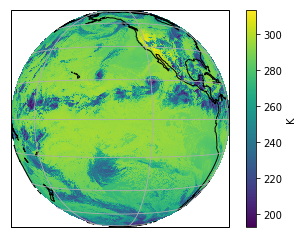

In [4]:
import glob
import matplotlib.pyplot as plt
from satpy import Scene


# Load data
filenames = glob.glob('goes15.2018.248.0000??.BAND_04.nc')
scene = Scene(filenames=filenames, reader='goes_14to15_nc')
scene.load(['10_7'])

# Resample to area definition with uniform sampling
area_def = scene['10_7'].attrs['area_def_uniform_sampling']  # full disc images only
resampled = scene.resample(area_def)

# Display results
crs = area_def.to_cartopy_crs()
ax = plt.axes(projection=crs)
ax.coastlines()
ax.gridlines()
plt.imshow(resampled['10_7'], transform=crs, extent=crs.bounds, origin='upper')
plt.colorbar(label=resampled['10_7'].attrs['units'])
plt.show()

## 4. Notes on calibration

### 4.1 Reflectance

Calibrating the visible channel to reflectance does not (yet) take into account the angle of incident radiation and the annual variation of the earth-sun distance. A value of 100% corresponds to the radiance of a perfectly reflecting diffuse surface
illuminated at normal incidence when the sun is at its annual-average distance from the Earth.

### 4.2 Calibration Error

The GOES Imager records multiple scanlines simultaneously in one sweep using multiple detectors (8 in VIS and 1-2 in IR channels). The calibration coefficients of the detectors in a channel vary slightly. Unfortunately there is no information in the netCDF files about which scanline was recorded by which detector. That is why the ``goes_nc`` reader uses the **average calibration coefficients** over all detectors in a channel to calibrate the raw image. 

Of course this approximation introduces an error. A worst case estimate of the error can be obtained by calibrating all possible counts with both the minimum and the maximum calibration coefficients and computing the difference. This is shown in the figures below. The table summarizes the worst case maximum errors.

<img src="goes_nc_ir_calib.png?!">
<center><figcaption>Fig.1: IR calibration error</figcaption></center>

<img src="goes_nc_vis_calib.png" width="450" height="450">
<center><figcaption>Fig.2: VIS calibration error</figcaption></center>

Platform | Channel | Error 
---------|---------|-------
GOES-8   |    00_7 | 0.0   % 
         |    03_9 | 0.187 K 
         |    06_8 | 0.0   K 
         |    10_7 | 0.106 K 
         |    12_0 | 0.036 K 
GOES-9   |    00_7 | 0.0   % 
         |    03_9 | 0.0   K 
         |    06_8 | 0.0   K 
         |    10_7 | 0.021 K
         |    12_0 | 0.006 K 
GOES-10  |    00_7 | 1-05  %
         |    03_9 | 0.0   K
         |    06_8 | 0.0   K
         |    10_7 | 0.013 K 
         |    12_0 | 0.004 K
GOES-11  |    00_7 | 1.25  %
         |    03_9 | 0.0   K
         |    06_8 | 0.0   K
         |    10_7 | 0.0   K
         |    12_0 | 0.065 K
GOES-12  |    00_7 | 0.8   %
         |    03_9 | 0.0   K
         |    06_5 | 0.044 K
         |    10_7 | 0.0   K
         |    13_3 | 0.0   K
GOES-13  |    00_7 | 1.31  %
         |    03_9 | 0.0   K
         |    06_5 | 0.085 K
         |    10_7 | 0.008 K
         |    13_3 | 0.0   K
GOES-14  |    00_7 | 0.66  %
         |    03_9 | 0.0   K
         |    06_5 | 0.043 K
         |    10_7 | 0.006 K
         |    13_3 | 0.003 K
GOES-15  |    00_7 | 0.86  %
         |    03_9 | 0.0   K
         |    06_5 | 0.02  K
         |    10_7 | 0.009 K
         |    13_3 | 0.008 K